In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
%cd /Users/sumeetdash/MAIA/Semester_3/CODES/MISA/Final_Project/MISA-MultiAtlas-Segmentation

/Users/sumeetdash/MAIA/Semester_3/CODES/MISA/Final_Project/MISA-MultiAtlas-Segmentation


/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from src.utils.helpers import load_nifti, save_nifti
from src.utils.sliding_window import extract_windows, merge_windows
from src.segmentation.fusion_methods import majority_vote, staple_fusion, probability_fusion
from src.evaluation.metrics import calculate_dice_score, hausdorff_distance, average_volumetric_difference
from src.segmentation.label_fusion_pipeline import LabelFusionPipeline
from src.segmentation.window_segmentation import window_based_segmentation

In [4]:
atlas_path = './Data/transformed_labels/IBSR_11'
fixed_image_path = './Data/SPM/Output/Validation_Set/IBSR_11/processed_mIBSR_11.nii'
ground_truth_path = './Data/SPM/Output/Validation_Set/IBSR_11/processed_IBSR_11_seg.nii'

In [5]:
# current_directory = os.getcwd()
# atlas_path = os.path.join(current_directory, 'Data/transformed_labels/IBSR_11')
# fixed_image_path = os.path.join(current_directory,'Data/Validation_Set/IBSR_11/IBSR_11.nii.gz')
# ground_truth_path = os.path.join(current_directory,'Data/Validation_Set/IBSR_11/IBSR_11_seg.nii.gz')

In [5]:
fixed_image, fixed_affine = load_nifti(fixed_image_path)
ground_truth, _ = load_nifti(ground_truth_path)

In [6]:
pipeline = LabelFusionPipeline(
    fixed_image=fixed_image,
    transformed_labels_dir = atlas_path
)

In [7]:
transformed_labels_dir = atlas_path

In [8]:
fusion_methods = {
    "Majority Voting": majority_vote
}

In [10]:
results = {}
for method_name, fusion_method in fusion_methods.items():
    print(f"Running {method_name}...")
    pipeline.load_transformed_labels()
    pipeline.apply_fusion(fusion_method)
    fused_result = pipeline.fused_label

    # # Save the result
    # output_path = os.path.join(output_dir, f"IBSR_11_{method_name.replace(' ', '_').lower()}.nii.gz")
    # save_nifti(fused_result, fixed_affine, output_path)
    # print(f"Saved result to {output_path}")

    # Evaluate and store metrics
    dice_score = calculate_dice_score(np.squeeze(ground_truth), fused_result)
    results[method_name] = {"Dice": dice_score}


Running Majority Voting...
Loaded 10 transformed labels.
Applied fusion strategy.


In [11]:
# Print evaluation metrics
print("\nEvaluation Metrics:")
for method_name, metrics in results.items():
    print(f"{method_name}: Dice = {sum(metrics['Dice'].values()) / len(metrics['Dice']):.4f}")
    print(f"{method_name}: Dice = {metrics['Dice']}")


Evaluation Metrics:
Majority Voting: Dice = 0.8405
Majority Voting: Dice = {1.0: 0.8309070548712206, 2.0: 0.8564463408164091, 3.0: 0.8340764302212293}


In [62]:
# Visualization
def visualize_results(fixed_image, ground_truth, results, slice_idx):
    """
    Visualize segmentation results on a single slice.
    Parameters:
        fixed_image (np.ndarray): Fixed image.
        ground_truth (np.ndarray): Ground truth segmentation.
        results (dict): Dictionary of segmentation results.
        slice_idx (int): Index of the slice to visualize.
    """
    plt.figure(figsize=(15, 10))

    # Fixed image
    plt.subplot(2, 3, 1)
    plt.imshow(fixed_image[:, :, slice_idx], cmap="gray")
    plt.title("Fixed Image")
    plt.axis("off")

    # Ground truth
    plt.subplot(2, 3, 2)
    plt.imshow(ground_truth[:, :, slice_idx], cmap="viridis")
    plt.title("Ground Truth")
    plt.axis("off")

    # Segmentation results
    for i, (method, metrics) in enumerate(results.items(), start=3):
        plt.subplot(2, 3, i)
        plt.imshow(metrics["Fused Result"][:, :, slice_idx], cmap="viridis")
        plt.title(f"{method}: Dice = {(sum(metrics['Dice'].values()) / len(metrics['Dice'])):.4f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Add fused results to `results` for visualization
for method_name, fusion_method in fusion_methods.items():
    results[method_name]["Fused Result"] = pipeline.fused_label

# Visualize on a middle slice
slice_idx = fixed_image.shape[2] // 2
visualize_results(fixed_image, ground_truth, results, slice_idx)

NameError: name 'fusion_methods' is not defined

# Window Test

In [8]:
import os
import nibabel as nib

def load_registered_images_and_labels(image_folder, label_folder):
    """
    Load registered images and corresponding label maps from specified folders.
    
    Parameters:
        image_folder (str): Path to the folder containing registered images.
                           Subfolders are named IBSR_01_to_IBSR_XX, each containing result.hdr.
        label_folder (str): Path to the folder containing label maps.
                           Files are named IBSR_01_to_IBSR_XX_seg_hdr.
    
    Returns:
        tuple: 
            - list of np.ndarray: Registered images sorted by names.
            - list of np.ndarray: Corresponding label maps sorted by names.
    """
    registered_images = []
    label_maps = []

    # Get sorted list of registered folders and label files
    registered_folders = sorted([d for d in os.listdir(image_folder) if d.startswith("IBSR_")])
    label_files = sorted([f for f in os.listdir(label_folder) if f.startswith("IBSR_") and "_seg.hdr" in f])

    # Ensure the lists are of the same length
    if len(registered_folders) != len(label_files):
        raise ValueError("Mismatch between number of registered folders and label map files.")

    for folder_name, label_name in zip(registered_folders, label_files):
        # Paths to registered image and label map
        folder_path = os.path.join(image_folder, folder_name)
        file_path = os.path.join(folder_path, "result.1.hdr")
        label_path = os.path.join(label_folder, label_name)

        # Load registered image
        if os.path.exists(file_path):
            registered_image = nib.load(file_path).get_fdata()
            registered_images.append(registered_image)
        else:
            print(f"Warning: Registered image not found: {file_path}")
            continue

        # Load label map
        if os.path.exists(label_path):
            label_map = nib.load(label_path).get_fdata()
            label_maps.append(label_map)
        else:
            print(f"Warning: Label map not found: {label_path}")
            continue

    return registered_images, label_maps

In [26]:
# Example input data
val_num = 17
images_folder = f"./Data/Elastix_Output/ParameterSet0009/IBSR_{val_num}"
labels_folder = f"./Data/transformed_labels/IBSR_{val_num}"
fixed_image_path = f"./Data/SPM/Output/Validation_Set/IBSR_{val_num}/processed_mIBSR_{val_num}.nii"
ground_truth_path = f"./Data/SPM/Output/Validation_Set/IBSR_{val_num}/processed_IBSR_{val_num}_seg.nii"
fixed_image, _ = load_nifti(fixed_image_path)  # Replace with your fixed image
ground_truth, _ = load_nifti(ground_truth_path)  # Replace with your ground truth
registered_images, label_maps = load_registered_images_and_labels(images_folder, labels_folder)
# label_maps = pipeline.transformed_labels  
# Parameters
window_size = (16, 16, 16)  # Adjust based on your dataset
stride = (16, 16, 16)       # Overlap between windows
fusion_strategy = "weighted_vote"  # Choose "majority_vote" or "weighted_vote"
metric = "ncc"             # Choose "ncc", "mse", or "entropy"

In [27]:
# Perform window-based segmentation and label fusion
fused_label_map = window_based_segmentation(
    fixed_image,
    registered_images,
    label_maps,
    window_size,
    stride,
    fusion_strategy,
    metric
)

# Output
print("Fused label map shape:", fused_label_map.shape)

Fused label map shape: (192, 128, 192)


In [28]:
results = {}
dice_score = calculate_dice_score(np.squeeze(ground_truth), fused_label_map)
results['window'] = {"Dice": dice_score}

In [29]:
# Print evaluation metrics
print("\nEvaluation Metrics:")
for method_name, metrics in results.items():
    print(f"{method_name}: Dice = {sum(metrics['Dice'].values()) / len(metrics['Dice']):.4f}")
    print(f"{method_name}: Dice = {metrics['Dice']}")


Evaluation Metrics:
window: Dice = 0.8706
window: Dice = {1.0: 0.8908291915334574, 2.0: 0.8905269160618353, 3.0: 0.8305494412461903}


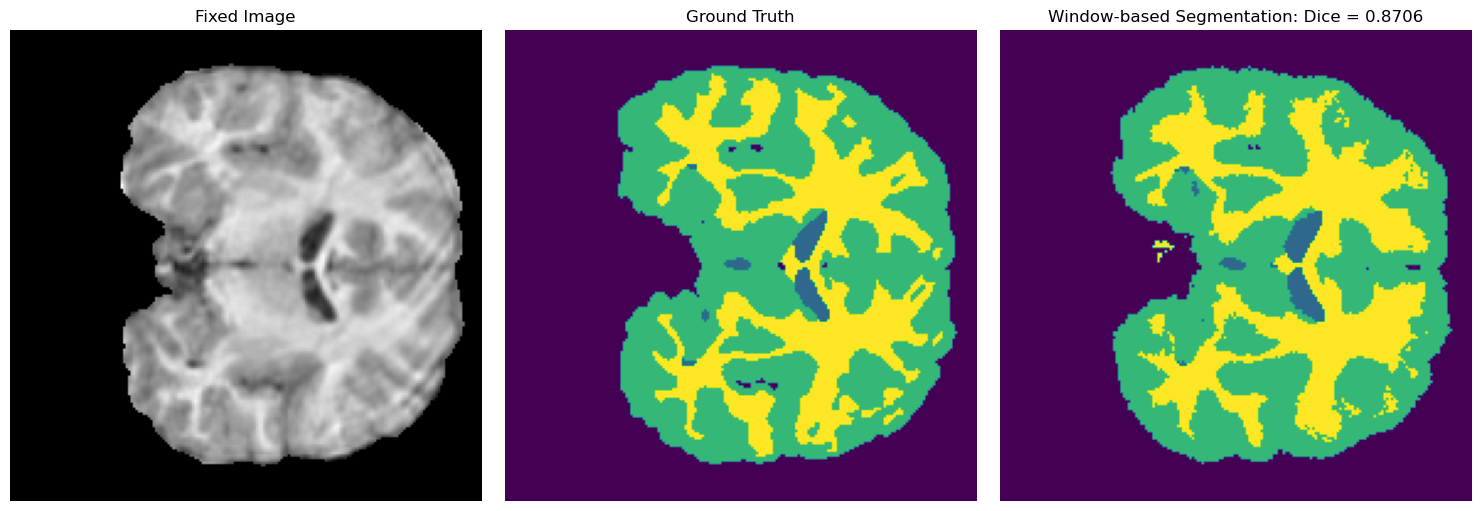

In [30]:
slice_idx = fixed_image.shape[1] // 2
plt.figure(figsize=(15, 10))

# Fixed image
plt.subplot(2, 3, 1)
plt.imshow(fixed_image[:, slice_idx, :], cmap="gray")
plt.title("Fixed Image")
plt.axis("off")

# Ground truth
plt.subplot(2, 3, 2)
plt.imshow(ground_truth[:, slice_idx, :], cmap="viridis")
plt.title("Ground Truth")
plt.axis("off")

# Segmentation results
plt.subplot(2, 3, 3)
plt.imshow(fused_label_map[:, slice_idx, :], cmap="viridis")
plt.title(f"Window-based Segmentation: Dice = {sum(dice_score.values()) / len(dice_score):.4f}")
plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
from itertools import product
val_num = 12
images_folder = f"./Data/Elastix_Output/ParameterSet0009/IBSR_{val_num}"
labels_folder = f"./Data/transformed_labels/IBSR_{val_num}"
fixed_image_path = f"./Data/SPM/Output/Validation_Set/IBSR_{val_num}/processed_mIBSR_{val_num}.nii"
ground_truth_path = f"./Data/SPM/Output/Validation_Set/IBSR_{val_num}/processed_IBSR_{val_num}_seg.nii"
fixed_image, _ = load_nifti(fixed_image_path)  # Replace with your fixed image
ground_truth, _ = load_nifti(ground_truth_path)  # Replace with your ground truth
registered_images, label_maps = load_registered_images_and_labels(images_folder, labels_folder)
# Define parameter grid
window_sizes = [(16, 16, 16), (32, 32, 32), (48, 48, 48)]
strides = [(8, 8, 8), (16, 16, 16)]
fusion_strategies = ["weighted_vote"]
metrics = ["ncc", "mse", "entropy", "mi"]


# Perform grid search
results = {}
for window_size, stride, fusion_strategy, metric in product(window_sizes, strides, fusion_strategies, metrics):
    print(f"Testing parameters: window_size={window_size}, stride={stride}, fusion_strategy={fusion_strategy}, metric={metric}")
    
    # Perform segmentation
    fused_label_map = window_based_segmentation(
        fixed_image,
        registered_images,
        label_maps,
        window_size,
        stride,
        fusion_strategy,
        metric
    )
    
    # Calculate Dice score
    dice_score = calculate_dice_score(np.squeeze(ground_truth), fused_label_map)
    
    
    # Store results
    param_key = f"window={window_size}_stride={stride}_fusion={fusion_strategy}_metric={metric}"
    results[param_key] = {"Dice": dice_score}


Testing parameters: window_size=(16, 16, 16), stride=(8, 8, 8), fusion_strategy=weighted_vote, metric=ncc
Testing parameters: window_size=(16, 16, 16), stride=(8, 8, 8), fusion_strategy=weighted_vote, metric=mse


KeyboardInterrupt: 

In [13]:
import os
import pandas as pd
from itertools import product

# Directories and parameters
validation_numbers = [11, 12, 13, 14, 17]
base_image_folder = "./Data/Elastix_Output/ParameterSet0009"
base_label_folder = "./Data/transformed_labels"
fixed_image_base_path = "./Data/SPM/Output/Validation_Set"
ground_truth_base_path = "./Data/SPM/Output/Validation_Set"

# Grid search parameters
window_sizes = [(16, 16, 16), (32, 32, 32), (48, 48, 48), (64, 64, 64)]
strides = [(16, 16, 16), (32, 32, 32), (48, 48, 48), (64, 64, 64)]  # Added stride (32, 32, 32)
fusion_strategies = ["weighted_vote"]
metrics = ["ncc", "mse", "entropy", "mi"]

# Dictionary to store results for all validation images
all_results = {}

# Iterate over all validation images
for val_num in validation_numbers:
    print(f"\nProcessing validation image: IBSR_{val_num}...")
    
    # Paths for the current validation image
    images_folder = f"{base_image_folder}/IBSR_{val_num}"
    labels_folder = f"{base_label_folder}/IBSR_{val_num}"
    fixed_image_path = f"{fixed_image_base_path}/IBSR_{val_num}/processed_mIBSR_{val_num}.nii"
    ground_truth_path = f"{ground_truth_base_path}/IBSR_{val_num}/processed_IBSR_{val_num}_seg.nii"
    
    # Load fixed image, ground truth, registered images, and label maps
    fixed_image, _ = load_nifti(fixed_image_path)  # Replace with your fixed image loader
    ground_truth, _ = load_nifti(ground_truth_path)  # Replace with your ground truth loader
    registered_images, label_maps = load_registered_images_and_labels(images_folder, labels_folder)
    
    # Perform grid search for the current validation image
    results = {}
    for window_size, stride, fusion_strategy, metric in product(window_sizes, strides, fusion_strategies, metrics):
        # Skip incompatible combinations
        if window_size != stride:
            continue
        
        print(f"  Testing parameters: window_size={window_size}, stride={stride}, fusion_strategy={fusion_strategy}, metric={metric}")
        
        # Perform segmentation
        fused_label_map = window_based_segmentation(
            fixed_image,
            registered_images,
            label_maps,
            window_size,
            stride,
            fusion_strategy,
            metric
        )
        
        # Calculate Dice score
        dice_score = calculate_dice_score(np.squeeze(ground_truth), fused_label_map)
        dice_score_mean = sum(dice_score.values()) / len(dice_score)
    
        # Store results
        param_key = f"window={window_size}_stride={stride}_fusion={fusion_strategy}_metric={metric}"
        results[param_key] = dice_array

    # Store results for the current validation image
    all_results[f"IBSR_{val_num}"] = results

# Convert results to a DataFrame
experiments = sorted(next(iter(all_results.values())).keys())  # Extract experiment names from the first validation result
results_table = pd.DataFrame(index=experiments)

for val_image, image_results in all_results.items():
    results_table[val_image] = [image_results[experiment] for experiment in experiments]

# Save results to a CSV file or display
results_table.to_csv("grid_search_results.csv")
print(results_table)


Processing validation image: IBSR_11...
  Testing parameters: window_size=(16, 16, 16), stride=(16, 16, 16), fusion_strategy=weighted_vote, metric=ncc
  Testing parameters: window_size=(16, 16, 16), stride=(16, 16, 16), fusion_strategy=weighted_vote, metric=mse
  Testing parameters: window_size=(16, 16, 16), stride=(16, 16, 16), fusion_strategy=weighted_vote, metric=entropy
  Testing parameters: window_size=(16, 16, 16), stride=(16, 16, 16), fusion_strategy=weighted_vote, metric=mi
  Testing parameters: window_size=(32, 32, 32), stride=(32, 32, 32), fusion_strategy=weighted_vote, metric=ncc
  Testing parameters: window_size=(32, 32, 32), stride=(32, 32, 32), fusion_strategy=weighted_vote, metric=mse
  Testing parameters: window_size=(32, 32, 32), stride=(32, 32, 32), fusion_strategy=weighted_vote, metric=entropy
  Testing parameters: window_size=(32, 32, 32), stride=(32, 32, 32), fusion_strategy=weighted_vote, metric=mi
  Testing parameters: window_size=(48, 48, 48), stride=(48, 48, 4

In [9]:
print("\nEvaluation Metrics:")
for method_name, metrics in results.items():
    print(f"{method_name}: Dice = {sum(metrics['Dice'].values()) / len(metrics['Dice']):.4f}")
    print(f"{method_name}: Dice = {metrics['Dice']}")


Evaluation Metrics:
window=(16, 16, 16)_stride=(8, 8, 8)_fusion=weighted_vote_metric=ncc: Dice = 0.8134
window=(16, 16, 16)_stride=(8, 8, 8)_fusion=weighted_vote_metric=ncc: Dice = {1.0: 0.746528444359122, 2.0: 0.8443174973992079, 3.0: 0.8492799495857293}
window=(16, 16, 16)_stride=(8, 8, 8)_fusion=weighted_vote_metric=mse: Dice = 0.8186
window=(16, 16, 16)_stride=(8, 8, 8)_fusion=weighted_vote_metric=mse: Dice = {1.0: 0.760427807486631, 2.0: 0.8493672639940884, 3.0: 0.8459368144851276}
window=(16, 16, 16)_stride=(8, 8, 8)_fusion=weighted_vote_metric=entropy: Dice = 0.7816
window=(16, 16, 16)_stride=(8, 8, 8)_fusion=weighted_vote_metric=entropy: Dice = {1.0: 0.6842893417540205, 2.0: 0.8295290333890104, 3.0: 0.8308452963437418}
window=(16, 16, 16)_stride=(16, 16, 16)_fusion=weighted_vote_metric=ncc: Dice = 0.8541
window=(16, 16, 16)_stride=(16, 16, 16)_fusion=weighted_vote_metric=ncc: Dice = {1.0: 0.857521815008726, 2.0: 0.8564478457703406, 3.0: 0.8482894136755353}
window=(16, 16, 16)_

# All Images


In [ ]:
import nibabel as nib
# Directories
validation_dir = './Data/SPM/Output/Validation_Set/'
transformed_labels_dir = './Data/transformed_labels/'
results = {}

# Iterate over all validation images
for folder_name in sorted(os.listdir(validation_dir)):
    # Define paths for current validation image
    fixed_image_path = os.path.join(validation_dir, folder_name, f"processed_m{folder_name}.nii")
    ground_truth_path = os.path.join(validation_dir, folder_name, f"processed_{folder_name}_seg.nii")
    atlas_path = os.path.join(transformed_labels_dir, folder_name)

    # Check if files exist
    if not os.path.exists(fixed_image_path) or not os.path.exists(ground_truth_path) or not os.path.exists(atlas_path):
        print(f"Skipping {folder_name}: Required files not found.")
        continue

    print(f"\nProcessing {folder_name}...")

    # Load fixed image and ground truth
    fixed_image = nib.load(fixed_image_path).get_fdata()
    ground_truth = nib.load(ground_truth_path).get_fdata()

    # Initialize results for this validation image
    results[folder_name] = {}

    # Process each fusion method
    for method_name, fusion_method in fusion_methods.items():
        print(f"  Running {method_name}...")

        # Load transformed labels
        pipeline = LabelFusionPipeline(fixed_image=fixed_image, transformed_labels_dir=atlas_path)
        pipeline.load_transformed_labels()
        pipeline.apply_fusion(fusion_method)

        # Store fused result and evaluate Dice score
        fused_result = pipeline.fused_label
        dice_scores = calculate_dice_score(np.squeeze(ground_truth), fused_result)  # Returns label-wise Dice
        hausdorff = hausdorff_distance(np.squeeze(ground_truth), fused_result, 4)  # Hausdorff distance
        average_volumetric = average_volumetric_difference(np.squeeze(ground_truth), fused_result, 4)  # Average Volume Difference
        # Store results
        results[folder_name][method_name] = {
            "Dice": dice_scores,  # Label-wise Dice
            "Average Dice": sum(dice_scores.values()) / len(dice_scores),  # Compute average
            "Hausdorff Distance": hausdorff, # Add Hausdorff distance if available
            "Average Hausdorff Distance": np.mean(hausdorff), # Add Average Hausdorff distance if available
            "Average Voulme Difference": average_volumetric, # Add Average Volume Difference if available
            "Avg. Volume Diff.": np.mean(average_volumetric)
        }


In [23]:
hausdorff = hausdorff_distance(np.squeeze(ground_truth.astype(np.int8)), fused_result, 4)  # Hausdorff distance

/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/monai/metrics/utils.py:334: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/monai/metrics/utils.py:334: UserWarning: the prediction of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 2 is all 0, this may

In [18]:
hausdorff

{0: 0.0, 1: nan, 2: nan, 3: nan}

In [19]:
ground_truth.shape

(192, 128, 192, 1)

In [20]:
fused_result.shape

(192, 128, 192)

In [23]:
import pandas as pd
import numpy as np

# Initialize a dictionary to store final average metrics across all validation images
final_averages = {
    "Method": [],
    "Average Dice": [],
    "Average Hausdorff Distance": [],
    "Average Volume Difference": []
}

# Compute averages across all validation images
for method_name in fusion_methods.keys():
    avg_dice = []
    avg_hausdorff = []
    avg_volume_diff = []
    
    for val_image, metrics in results.items():
        if method_name in metrics:
            avg_dice.append(metrics[method_name]["Average Dice"])
            avg_hausdorff.append(metrics[method_name]["Average Hausdorff Distance"])
            avg_volume_diff.append(metrics[method_name]["Avg. Volume Diff."])

    # Calculate overall averages for the current method
    final_averages["Method"].append(method_name)
    final_averages["Average Dice"].append(np.mean(avg_dice))
    final_averages["Average Hausdorff Distance"].append(np.mean(avg_hausdorff))
    final_averages["Average Volume Difference"].append(np.mean(avg_volume_diff))

# Convert final averages to a DataFrame
final_averages_df = pd.DataFrame(final_averages)

# Save the final averages to a CSV or display as a table
final_averages_df.to_csv("final_averages.csv", index=False)
print(final_averages_df)

            Method  Average Dice  Average Hausdorff Distance  \
0  Majority Voting           NaN                         NaN   

   Average Volume Difference  
0                        NaN  


/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sumeetdash/anaconda3/envs/ML_Environment/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
